# ML Pipeline

V3 : simple pipeline with few features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from region_new import Region
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

from ml.add_all_features import *
from ml.preprocessing import *
from ml.model import *

In [3]:
from region_new.utils import rasters_to_mosaic
from rasterio.merge import merge

In [4]:
rasters_to_mosaic('wsf', 'Cairo')

In [5]:
rasters_to_mosaic('wsf', 'Johannesburg')

### ML Pipeline on Turkish Cities

##### Prepare the four cities `(skip if pickled)`

In [6]:
ordu_path = os.path.join("data", "ml", "Ordu.pkl")
manisa_path = os.path.join("data", "ml", "Manisa.pkl")
adana_path = os.path.join("data", "ml", "Adana.pkl")
trabzon_path = os.path.join("data", "ml", "Trabzon.pkl")

In [7]:
with open(ordu_path, 'rb') as f:     
    ordu = pickle.load(f)
    f.close()
with open(adana_path, 'rb') as f:     
    adana = pickle.load(f)
    f.close()
with open(manisa_path, 'rb') as f:     
    manisa = pickle.load(f)
    f.close()
with open(trabzon_path, 'rb') as f:     
    trabzon = pickle.load(f)
    f.close()

In [8]:
ordu = add_all_features(ordu,  'Ordu')
manisa = add_all_features(manisa,  'Manisa')
adana = add_all_features(adana, 'Adana')
trabzon = add_all_features(trabzon,  'Trabzon')

adding polygons... 
adding denstity... 
adding area... 
adding rasters... 


/home/matt/.local/lib/python3.10/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


adding polygons... 
adding denstity... 
adding area... 
adding rasters... 


/home/matt/.local/lib/python3.10/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


adding polygons... 
adding denstity... 
adding area... 
adding rasters... 


/home/matt/.local/lib/python3.10/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


adding polygons... 
adding denstity... 
adding area... 
adding rasters... 


/home/matt/.local/lib/python3.10/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [9]:
data = merge_cities([ordu, manisa, adana, trabzon])
data.isna().sum()

/home/matt/wb_cities/ml/preprocessing.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_next)
/home/matt/wb_cities/ml/preprocessing.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_next)
/home/matt/wb_cities/ml/preprocessing.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_next)


height          266877
orient          271352
type_level_0    267057
density              0
area                 0
source           40907
geometry             0
type_level_1    267273
type_level_2     41414
ntl                  0
lcz                  0
index_right          0
wsf                  0
city                 0
dtype: int64

##### Polygons Filtering

We filter polygons with the WSF mask.

<AxesSubplot:>

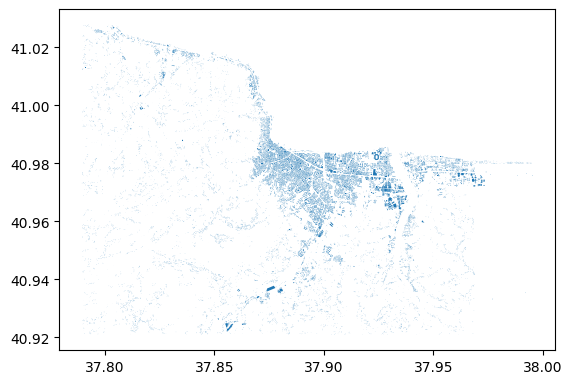

In [10]:
data[data.city=='Ordu'].plot()

<AxesSubplot:>

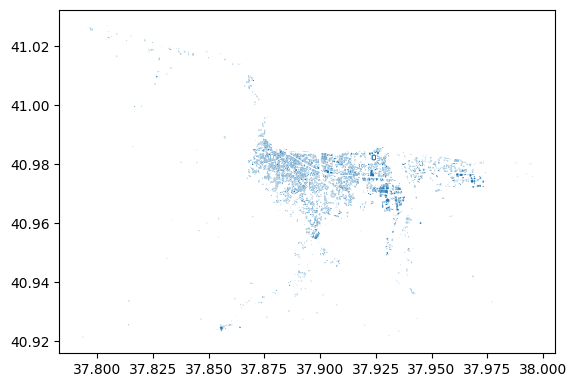

In [11]:
data = data[data.wsf > 0.0]
data[data.city=='Ordu'].plot()

In [13]:
data = format_type(data)
data['residential'].isna().sum()

126170

In [14]:
# Data Preparation for the whole country is quite long.
# So better save the result to spare some computation time
turkey_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(turkey_path,"wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
turkey_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(turkey_path,"rb") as f:
    data = pickle.load(f)

Although we lose *some* meaningful polygons in the process -- WSF is not 100% accurate -- we also likely get rid of MSB false-positives while keeping the urban residential areas mostly untouched.

##### Preprocessor

In [15]:
data = clean_columns(data)
train, pred = split(data, 'residential')
X, y = training_split(train, 'residential')
print(X.shape, y.shape)
preprocessor = preprocesor()

(20520, 8) (20520,)


(16416, 8) (16416,)
5327     0.0
14678    1.0
16809    1.0
18548    1.0
14867    1.0
        ... 
7672     1.0
8655     1.0
4757     1.0
1397     1.0
14317    1.0
Name: residential, Length: 16416, dtype: float64
BalancedRandomForestClassifier()
Score :  0.8709797231743789
BalancedBaggingClassifier()
Score :  0.8773147610526749


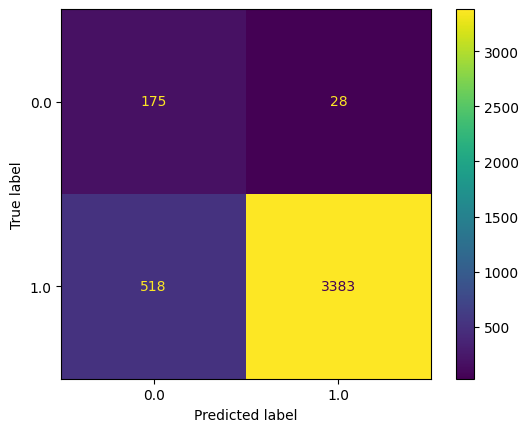

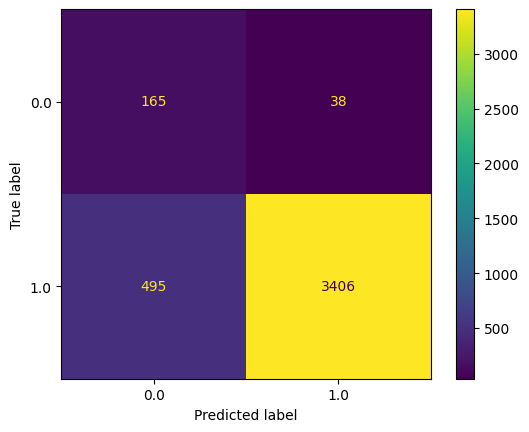

In [37]:
model = select_best_estimator(X, y, preprocessor)

In [38]:
# "Turkey"   : LCZ, NTL, WSF
# "Turkey_2" : LCZ, NTL, WSF, GHSL-H
model_path = os.path.join("data", "ml", "models", "Turkey_residential.pkl")
with open(model_path,"wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
data_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(data_path,"rb") as f:
   data = pickle.load(f)

In [40]:
prediction = predict(model, 'residential', train, pred, data)

In [41]:
predictions_list = breakdown_cities(prediction)

Trabzon
Ordu
Adana
Manisa


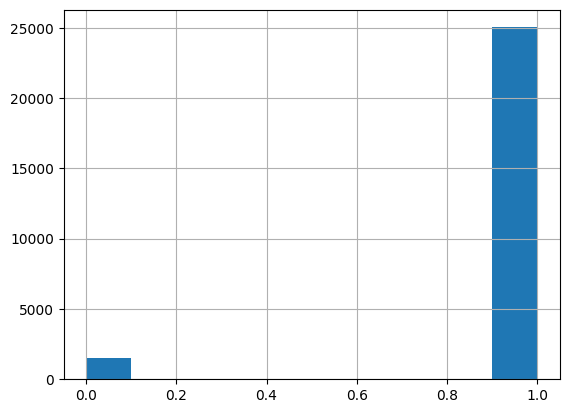

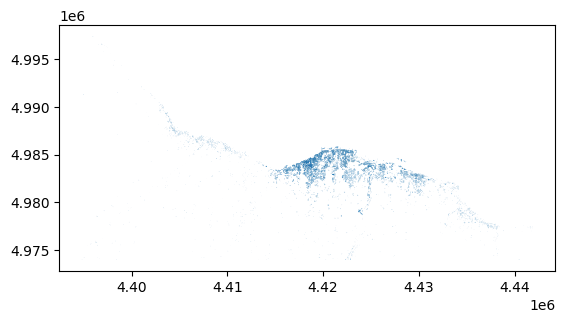

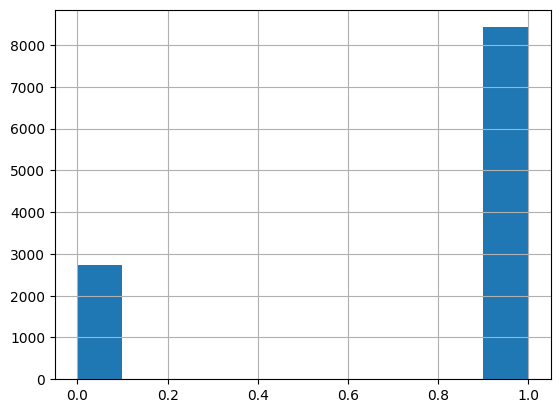

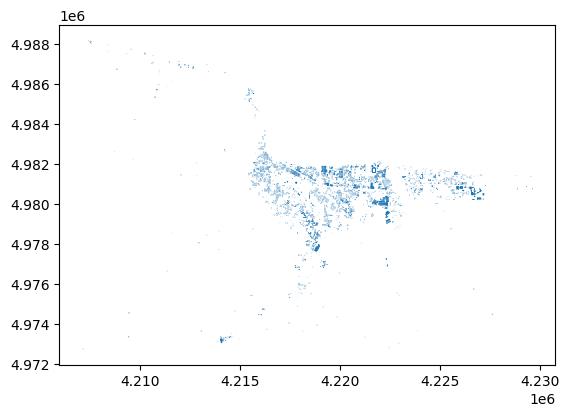

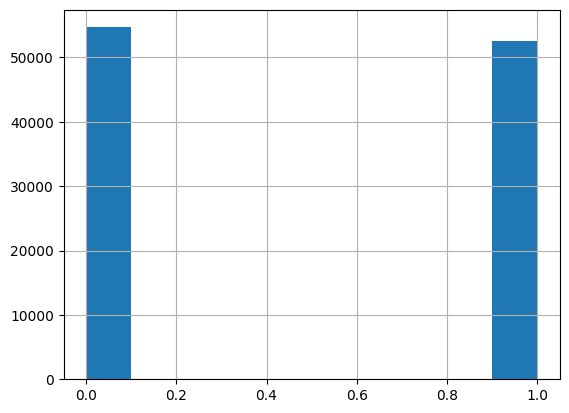

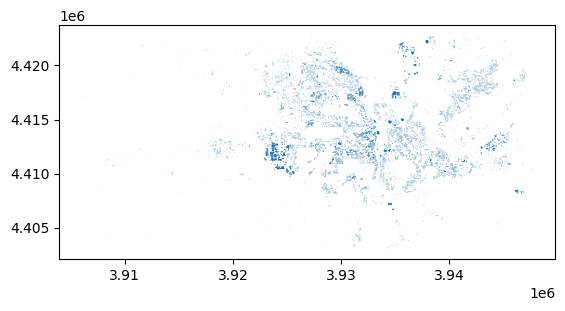

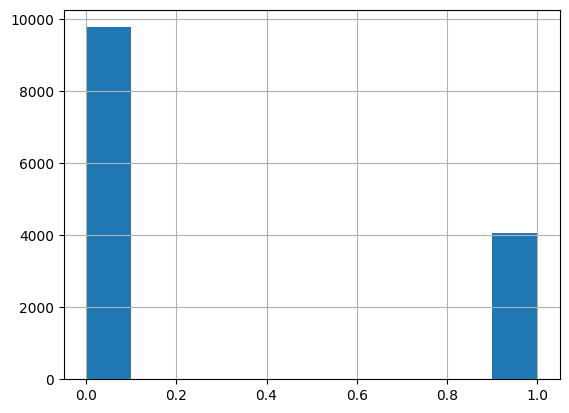

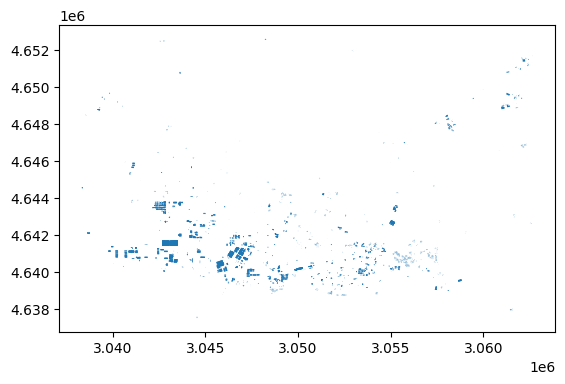

In [42]:
for prediction in predictions_list:
    city = prediction.city.unique()[0]
    print(city)
    result = prediction[ prediction.city == city ]
    plt.figure()
    result.residential_pred.hist()
    result = result[ result.residential_pred == 1 ]
    result_path = os.path.join("data", "ml", "prediction", 'type', city+".pkl")
    with open(model_path,"wb") as f:
        pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)
    result.plot()

In [ ]:
for prediction in predictions_list:
    city = prediction.city.unique()[0]
    print(city)
    result = prediction_to_raster(prediction, 'height_pred')
    write_result(result, 'height', city)

##### Visual Outputs

###### 

In [ ]:
ordu_path = os.path.join("data", "ml", "prediction", "type", "Ordu.tif")
manisa_path = os.path.join("data", "ml", "prediction", "type", "Manisa.tif")
adana_path = os.path.join("data", "ml", "prediction", "type", "Adana.tif")
trabzon_path = os.path.join("data", "ml", "prediction", "type", "Trabzon.tif")

In [ ]:
ordu = rasterio.open(ordu_path)
manisa = rasterio.open(manisa_path)
adana = rasterio.open(adana_path)
trabzon = rasterio.open(trabzon_path)

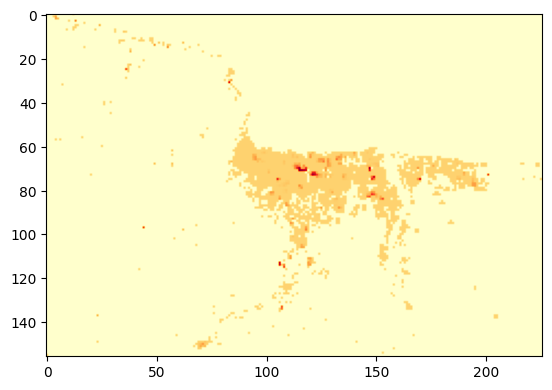

In [ ]:
plt.imshow(ordu.read(1), cmap="YlOrRd")

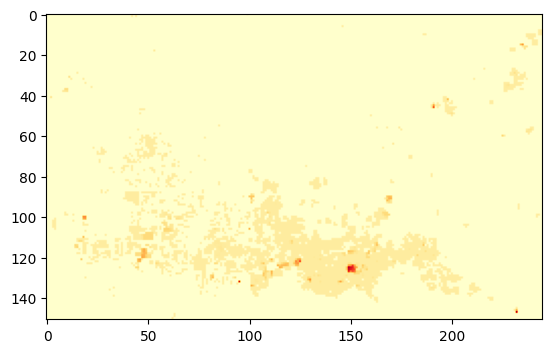

In [ ]:
plt.imshow(manisa.read(1), cmap="YlOrRd")

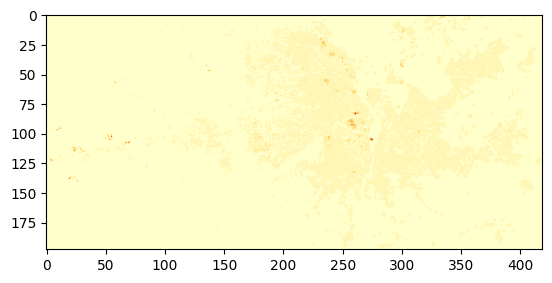

In [ ]:
plt.imshow(adana.read(1), cmap="YlOrRd")

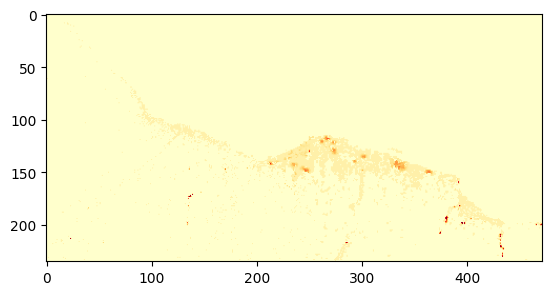

In [ ]:
plt.imshow(trabzon.read(1), cmap="YlOrRd")

### Cairo

In [ ]:
cairo_path = os.path.join("data", "ml", "Cairo.pkl")
with open(cairo_path, 'rb') as f:     
    cairo = pickle.load(f)
cairo = add_all_features(cairo,  'Cairo')

In [ ]:
cairo = cairo[cairo.wsf > 0.0]
cairo_path = os.path.join("data", "ml", "datasets", "Cairo.pkl")
with open(cairo_path,"wb") as f:
    pickle.dump(cairo, f, protocol=pickle.HIGHEST_PROTOCOL)
cairo.isna().sum()

In [ ]:
cairo_path = os.path.join("data", "ml", "datasets", "Cairo.pkl")
with open(cairo_path,"rb") as f:
    cairo = pickle.load(f)
cairo = clean_columns(cairo)
train, pred = split(cairo)
X, y = training_split(train, 'height')
print(X.shape, y.shape)
preprocessor = preprocesor()
model = select_best_estimator(X, y, preprocessor)

In [ ]:
model_path = os.path.join("data", "ml", "models", "Cairo.pkl")
with open(model_path,"wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_path = os.path.join("data", "ml", "models", "Cairo.pkl")
with open(model_path,"rb") as f:
   model = pickle.load(f)

In [ ]:
cairo_path = os.path.join("data", "ml", "datasets", "Cairo.pkl")
with open(cairo_path,"rb") as f:
    cairo = pickle.load(f)
prediction = predict(model, 'height', train, pred, cairo)

In [ ]:
result = prediction_to_raster(prediction, 'height_pred')
write_result(result, 'height', 'Cairo')

### Johannesburg

In [43]:
johannesburg_path = os.path.join("data", "ml", "Johannesburg.pkl")
with open(johannesburg_path, 'rb') as f:     
    johannesburg = pickle.load(f)
    f.close()
johannesburg = add_all_features(johannesburg,  'Johannesburg')

adding polygons... 


In [ ]:
johannesburg = johannesburg[johannesburg.wsf > 0.0]
johannesburg_path = os.path.join("data", "ml", "datasets", "Johannesburg.pkl")
with open(johannesburg_path,"wb") as f:
    pickle.dump(johannesburg, f, protocol=pickle.HIGHEST_PROTOCOL)
johannesburg.isna().sum()

In [ ]:
johannesburg_path = os.path.join("data", "ml", "datasets", "Johannesburg.pkl")
with open(johannesburg_path,"rb") as f:
    johannesburg = pickle.load(f)
johannesburg = clean_columns(johannesburg)
train, pred = split(johannesburg)
X, y = training_split(train, 'height')
print(X.shape, y.shape)
preprocessor = preprocesor()
model = select_best_estimator(X, y, preprocessor)

In [ ]:
model_path = os.path.join("data", "ml", "models", "Johannesburg.pkl")
with open(model_path,"wb") as f:    
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_path = os.path.join("data", "ml", "models", "Johannesburg.pkl")
with open(model_path,"rb") as f:
   model = pickle.load(f)

In [ ]:
johannesburg_path = os.path.join("data", "ml", "datasets", "Johannesburg.pkl")
with open(johannesburg_path,"rb") as f:
    johannesburg = pickle.load(f)
prediction = predict(model, 'height', train, pred, johannesburg)

In [ ]:
result = prediction_to_raster(prediction, 'height_pred')
write_result(result, 'height', 'Johannesburg')